# Jimmy Liang

CMPE 258 Assignment 4

SJSU 001869817

# Import the MNIST dataset, normalize and visualization

In [123]:
import numpy as np
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [124]:
#Reshaping the training set and setting up the one hot encoded labels

#X_train = X_train.reshape(len(X_train),28*28) / 255
#y_train = y_train

X_train, y_train = (x_train[0:10000].reshape(10000,28*28) / 255, y_train[0:10000])


one_hot_labels = np.zeros((len(y_train),10))

for i,l in enumerate(y_train):
    one_hot_labels[i][l] = 1
y_train = one_hot_labels

In [125]:
print('Image dataset shape is:', X_train.shape)
print('Label dataset shape is:', y_train.shape)


Image dataset shape is: (10000, 784)
Label dataset shape is: (10000, 10)


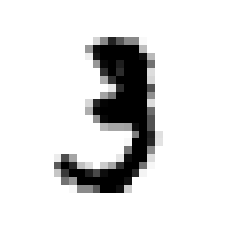

Label is [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [126]:
#Visualizing one of the digits

import matplotlib as mpl
import matplotlib.pyplot as plt
digit = 10

some_digit = X_train[digit]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()
print("Label is", y_train[digit])

In [127]:
# Do the same thing for the test set

X_test = x_test.reshape(len(x_test),28*28) / 255
y_test = y_test

one_hot_labels = np.zeros((len(y_test),10))

for i,l in enumerate(y_test):
    one_hot_labels[i][l] = 1
y_test = one_hot_labels

In [128]:
print('Test dataset shape is:', X_test.shape)
print('Label dataset shape is:', y_test.shape)

Test dataset shape is: (10000, 784)
Label dataset shape is: (10000, 10)


# Training using Numpy

## Define some helper functions and hyper parameters

In [129]:
# Activations

def relu(x):
    return (x >= 0) * x
def relu2deriv(output):
    return output >= 0 

In [130]:
# Hyper Parameters
batch_size = 100
learning_rate, iterations = (0.001, 300)
pixels_per_image, num_labels, hidden_size = (784, 10, 100)

weights_0_1 = 0.2*np.random.random((pixels_per_image,hidden_size)) - 0.1
weights_1_2 = 0.2*np.random.random((hidden_size,num_labels)) - 0.1

## Training

In [131]:
for j in range(iterations):
    error, correct_cnt = (0.0, 0)
    for i in range(int(len(X_train) / batch_size)):
        batch_start, batch_end = ((i * batch_size),((i+1)*batch_size))

        layer_0 = X_train[batch_start:batch_end]
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask = np.random.randint(2,size=layer_1.shape)
        layer_1 *= dropout_mask * 2
        layer_2 = np.dot(layer_1,weights_1_2)

        error += np.sum((y_train[batch_start:batch_end] - layer_2) ** 2)
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(y_train[batch_start+k:batch_start+k+1]))

            layer_2_delta = (y_train[batch_start:batch_end]-layer_2)/batch_size
            layer_1_delta = layer_2_delta.dot(weights_1_2.T)* relu2deriv(layer_1)
            layer_1_delta *= dropout_mask

            weights_1_2 += learning_rate * layer_1.T.dot(layer_2_delta)
            weights_0_1 += learning_rate * layer_0.T.dot(layer_1_delta)
            
    if(j%10 == 0):
        test_error = 0.0
        test_correct_cnt = 0

        for i in range(len(X_test)):
            layer_0 = X_test[i:i+1]
            layer_1 = relu(np.dot(layer_0,weights_0_1))
            layer_2 = np.dot(layer_1, weights_1_2)

            test_error += np.sum((y_test[i:i+1] - layer_2) ** 2)
            test_correct_cnt += int(np.argmax(layer_2) == np.argmax(y_test[i:i+1]))

        print("Iteration:", j, "Test Accuracy: ", test_correct_cnt/ float(len(X_test)), "Training Accuracy: ", correct_cnt/ float(len(X_train)) )

Iteration: 0 Test Accuracy:  0.094 Training Accuracy:  0.1007
Iteration: 10 Test Accuracy:  0.1482 Training Accuracy:  0.1488
Iteration: 20 Test Accuracy:  0.1508 Training Accuracy:  0.179
Iteration: 30 Test Accuracy:  0.1537 Training Accuracy:  0.1866
Iteration: 40 Test Accuracy:  0.1964 Training Accuracy:  0.1852
Iteration: 50 Test Accuracy:  0.215 Training Accuracy:  0.1856
Iteration: 60 Test Accuracy:  0.2032 Training Accuracy:  0.1832
Iteration: 70 Test Accuracy:  0.1911 Training Accuracy:  0.1857
Iteration: 80 Test Accuracy:  0.211 Training Accuracy:  0.1987
Iteration: 90 Test Accuracy:  0.2428 Training Accuracy:  0.2176
Iteration: 100 Test Accuracy:  0.2783 Training Accuracy:  0.2445
Iteration: 110 Test Accuracy:  0.3317 Training Accuracy:  0.2743
Iteration: 120 Test Accuracy:  0.4224 Training Accuracy:  0.3187
Iteration: 130 Test Accuracy:  0.5126 Training Accuracy:  0.3659
Iteration: 140 Test Accuracy:  0.5727 Training Accuracy:  0.4086
Iteration: 150 Test Accuracy:  0.6023 Tr

# Training using Keras

In [55]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import layers
from keras import backend as K

## Reshaping images and defining hyper-parameters

In [84]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [88]:
# Shapes

print("Training data shape: ", x_train.shape)
print("Training label shape: ", y_train.shape)
print("testing data shape: ", x_test.shape)
print("testing label shape: ", y_test.shape)

Training data shape:  (60000, 28, 28, 1)
Training label shape:  (60000, 10)
testing data shape:  (10000, 28, 28, 1)
testing label shape:  (10000, 10)


## Creating the model

In [90]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model parameters = 1199882
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_51 (Dropout)      

## Training

In [99]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 42s 98ms/step - loss: 0.7572 - accuracy: 0.7668 - val_loss: 0.0838 - val_accuracy: 0.9787
Epoch 2/15
422/422 [==============================] - 41s 98ms/step - loss: 0.1214 - accuracy: 0.9638 - val_loss: 0.0653 - val_accuracy: 0.9832
Epoch 3/15
422/422 [==============================] - 42s 98ms/step - loss: 0.0883 - accuracy: 0.9724 - val_loss: 0.0521 - val_accuracy: 0.9863
Epoch 4/15
422/422 [==============================] - 41s 98ms/step - loss: 0.0708 - accuracy: 0.9783 - val_loss: 0.0438 - val_accuracy: 0.9883
Epoch 5/15
422/422 [==============================] - 40s 96ms/step - loss: 0.0638 - accuracy: 0.9800 - val_loss: 0.0456 - val_accuracy: 0.9878
Epoch 6/15
422/422 [==============================] - 42s 99ms/step - loss: 0.0551 - accuracy: 0.9819 - val_loss: 0.0400 - val_accuracy: 0.9885
Epoch 7/15
422/422 [==============================] - 41s 97ms/step - loss: 0.0508 - accuracy: 0.9834 - val_loss: 0.0373 - val_accuracy: